In [1]:
%%writefile src/Python/ICGC_data_parser/ssm_reader.py
"""
Module with functionality to read the ICGC
simple somatic mutations file.
"""

import vcf
import re
from collections import namedtuple


class BufferedReader:
    """A wrapper over a file descriptor that adds buffering functionality."""
    def __init__(self, fdesc):
        self.file = fdesc
        self.buffer = []
    # ---
    
    def __getattr__(self, attr):
        return getattr(self.file, attr)
    # ---
    
    def push(self, line):
        self.buffer.append(line)
    # ---
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.buffer:
            return self.buffer.pop()
        return next(self.file)
    # ---
# --- BufferedReader


class SSM_Reader(vcf.Reader):
    """Reader class for the International Cancer Genome 
    Consortium aggregate file of simple somatic mutations
    from the Data Releases.
    
    Example::
        
            >>> reader = SSM_Reader(filename='data/ssm_sample.vcf')

            >>> for record in reader.parse(filters=['BRCA-EU']):
            ...    print(record.ID, record.CHROM, record.POS)
            MU66865518 1 100141201
            MU65487875 1 100160548
            MU66281118 1 100638179
            MU66254120 1 101352655
                ...
    """
    
    def __init__(self, *args, buffered=False, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Add buffering 
        self.reader = BufferedReader(self.reader)
        self.re_filters = []
    # --- 
    
    def push_line(self, line):
        self.reader.push(line)
    # ---
    
    def iter_lines(self):
        return self.reader
    # ---
    
    def next_line(self):
        return next(self.reader)
    # ---
    
    def next_array(self):
        return next(self.reader).split('\t')
    # ---
    
    def subfield_parser(self, sf_name, sep='|'):
        """Get a parser for the items of the subfield.
        
        Useful to parse the CONSEQUENCE and OCCURRENCE subfields
        of the INFO field.
        
        Example::
        
            >>> reader = SSM_Reader(filename='data/ssm_sample.vcf')
            
            >>> CONSEQUENCE = reader.subfield_parser('CONSEQUENCE')

            >>> for record in reader.parse(filters=['BRCA-EU']):
            ...    # Which genes are affected?
            ...    print(CONSEQUENCE(record)[0].gene_symbol)
            SLC27A3
            GATAD2B
            TPM3
            SHE
            ADAM15
              ...    
        """
        # Get the description of the subfield
        sf_info = self.infos[sf_name]
        
        # Get the field id
        field_id = sf_info.id

        # Get the subfields names
        subfields_str = re.findall("\(subfields: (.*?)\)", sf_info.desc)[0]
        subfields = subfields_str.split(sep)

        # Create the structure
        field_struct = namedtuple(field_id, subfields)

        # Create parser
        def parse(record):
            # Parse the field items
            return [field_struct(*item.split(sep)) 
                        for item in record.INFO[field_id]
                        if item]

        parse.field_id = sf_info.id
        parse.subfields = subfields
        return parse
    # ---
    
    def parse_lines(self, filters=None):
        """Iterate through the file, filtering out the 
        lines not matching the regular expressions given.  
        """
        if filters is None:
            filters = []
            
        # Compile filters for faster lookup
        filters = [re.compile(regex) 
                       for regex in filters 
                       if regex is not None]
        
        for line in self.reader:
            if all(filter_.search(line) for filter_ in filters):
                   # The line passes all filters
                   yield line
    # ---
                   
    def parse(self, filters=None):
        """Iterate through the records of the file, 
        filtering out the lines that do not match the 
        regular expressions given.
        
        Example::
        
            >>> reader = SSM_Reader(filename='data/ssm_sample.vcf')

            >>> for record in reader.parse(filters=['BRCA-EU']):
            ...    print(record.ID)
            MU66865518
            MU65487875
            MU66281118
            MU66254120
                ...
            
        """
        for line in self.parse_lines(filters=filters):
            # The parser reads the record from
            # self.reader, so, we must rebuffer 
            # the line to parse it.
            self.reader.push(line)
            yield next(self)
    # ---
# SSM_Reader

Overwriting src/Python/ICGC_data_parser/ssm_reader.py


In [40]:
# Helper function to test
from itertools import islice

def head(iterable, items=10):
    'Return the first items of an iterator.'
    iterator = iter(iterable)
    return islice(iterator, items)
# ---

[item for item in head(range(100), items=5)]

[0, 1, 2, 3, 4]

In [9]:
import src.Python.ICGC_data_parser as dp

In [31]:
reader = dp.SSM_Reader(filename="data/ssm_sample.vcf", buffered=True)

In [32]:
# Checking the reader
print(next(reader))

Record(CHROM=1, POS=100006117, REF=G, ALT=[A])


In [33]:
# Reading raw lines
print(reader.next_line())

1	100019738	MU57116993	G	T	.	.	CONSEQUENCE=||||||intergenic_region||;OCCURRENCE=LUSC-KR|1|66|0.01515;affected_donors=1;mutation=G>T;project_count=1;studies=.;tested_donors=12068


In [49]:
reader = dp.SSM_Reader(filename='data/ssm_sample.vcf')

for record in head(reader.parse(filters=['BRCA-EU'])):
    print(record.ID, record.CHROM, record.POS)

MU66865518 1 100141201
MU65487875 1 100160548
MU66281118 1 100638179
MU66254120 1 101352655
MU65592106 1 101354415
MU63863018 1 102192768
MU66309268 1 102435620
MU64254259 1 102697175
MU63543981 1 103240746
MU64836859 1 103303624


# Testing buffering

In [34]:
# Fetch a line
line = reader.next_line()
print(line.split('\t')[2]) # Print mutation ID

# Rebuffer the line 
reader.reader.push(line)

# Fetch buffered line as record, 
print(next(reader).ID)

MU34331173
MU34331173


In [35]:
"""Testing buffering in action.

Application: Search lines that match regex
and analyze them as a record.
"""

import re

project = re.compile('BRCA-EU') # Query string

for line in head(reader.iter_lines()):
    if project.search(line):
        # Line matches query.
        # Print mutation ID
        # from raw line
        print(line.split('\t')[2], end=' ') 
        
        # Rebuffer line
        reader.reader.push(line)
        
        # Fetch as record and print ID
        print(next(reader).ID)

MU66865518 MU66865518
MU65487875 MU65487875


# File parsing

In [37]:
reader = dp.SSM_Reader(filename='data/ssm_sample.vcf')

for record in reader.parse(filters=['BRCA-EU', 'TP53']):
    print(record.ID)
    print(record.INFO)

MU67273947
{'CONSEQUENCE': ['TP53BP1|ENSG00000067369|1|TP53BP1-002|ENST00000263801||intron_variant||', 'TP53BP1|ENSG00000067369|1|TP53BP1-004|ENST00000382039||intron_variant||', 'TP53BP1|ENSG00000067369|1|TP53BP1-001|ENST00000382044||intron_variant||', 'TP53BP1|ENSG00000067369|1|TP53BP1-011|ENST00000411772||intron_variant||', 'TP53BP1|ENSG00000067369|1|TP53BP1-005|ENST00000413546||downstream_gene_variant||', 'TP53BP1|ENSG00000067369|1|TP53BP1-008|ENST00000417342||intron_variant||', 'TP53BP1|ENSG00000067369|1|TP53BP1-014|ENST00000450115||intron_variant||', 'TP53BP1|ENSG00000067369|1|TP53BP1-013|ENST00000467474||upstream_gene_variant||', 'TP53BP1|ENSG00000067369|1|TP53BP1-015|ENST00000572085||intron_variant||'], 'OCCURRENCE': ['BRCA-EU|1|569|0.00176'], 'affected_donors': 1, 'mutation': 'G>A', 'project_count': 1, 'studies': 'PCAWG', 'tested_donors': 12068}


## INFO subfields parsing

In [39]:
reader = dp.SSM_Reader(filename='data/ssm_sample.vcf')
            
CONSEQUENCES = reader.subfield_parser('CONSEQUENCE')

for record in head(reader.parse(filters=['BRCA-EU'])):
    # Which genes are affected?
    print(CONSEQUENCES(record)[0].gene_symbol)

PALMD

LRRC39
EXTL2
EXTL2
RP11-411H5.1
OLFM3
RP11-202K23.1
RP5-936J12.1
RP5-936J12.1


# Use case: Mutation recurrence distribution.

How many mutations appear in multiple patients? or, specifying further, How many mutations are repeated in n different patients in a given cancer project? This data is concentrated in the mutation recurrence distribution.

In [51]:
%%time
from collections import Counter
from src.Python.ICGC_data_parser import SSM_Reader

def recurrence_data(mutation, parser):
    "Fetch the recurrence data for a given mutation."
    recurrence_by_project = {occ.project_code:{'affected_donors': occ.affected_donors,
                                               'tested_donors': occ.tested_donors} 
                                     for occ in parser(mutation)}
    return {'mutation_id' : mutation.ID,
            'proj_recurrence' : recurrence_by_project,
            'total_affected_donors': mutation.INFO['affected_donors'],
            'total_tested_donors': mutation.INFO['tested_donors']}
# ---


def recurrence_distribution(filename, project=None, filters=None):
    """Searches through input file for mutations related to 
    the given cancer project.

    Gets the mutation recurrence distribution for the data 
    (i.e. how many mutations are repeated in ``n`` different 
    patients?)
    """
    if filters is None:
        filters = []
    
    # Open mutations file
    reader = SSM_Reader(filename=filename)
    OCCURRENCES = reader.subfield_parser('OCCURRENCE')

    # Initialize distribution
    tested_donors = None
    distribution = Counter()

    for record in reader.parse(filters=[project]+filters):
        recurrence = recurrence_data(record, OCCURRENCES)

        if project: # When a project is specified
            proj_recurrence = recurrence['proj_recurrence'][project]
            proj_affected = proj_recurrence['affected_donors']
            distribution[int(proj_affected)] += 1

            if tested_donors is None:
                tested_donors = proj_recurrence['tested_donors']
                
        else: # When all projects are parsed
            total_affected = recurrence['total_affected_donors']
            distribution[int(total_affected)] += 1

            if tested_donors is None:
                tested_donors = recurrence['total_tested_donors']
                
    return distribution, tested_donors
# ---

distribution, tested_donors = recurrence_distribution('data/ssm_sample.vcf')

CPU times: user 10.8 s, sys: 20 ms, total: 10.8 s
Wall time: 10.8 s


In [52]:
sum(distribution.values()) # The number of mutations analyzed

99741

In [53]:
distribution

Counter({1: 92085,
         2: 6042,
         3: 987,
         4: 326,
         5: 132,
         6: 61,
         7: 35,
         8: 26,
         9: 15,
         10: 12,
         11: 10,
         12: 2,
         13: 1,
         14: 3,
         15: 2,
         20: 1,
         21: 1})

In [54]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

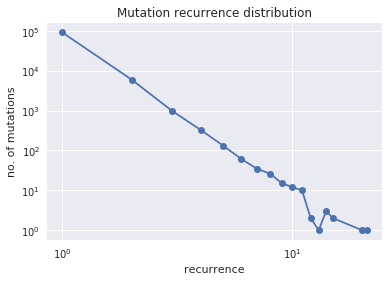

In [55]:
x = sorted(distribution.keys())
y = [distribution[i] for i in x]

plt.plot(x, y, marker='o')
plt.yscale('log')
plt.xscale('log')
plt.title('Mutation recurrence distribution')
plt.xlabel('recurrence')
plt.ylabel('no. of mutations')
plt.show()